In [1]:
import warnings
warnings.filterwarnings("ignore")


import numpy as np
from numba import jit,cuda
from numba.cuda.random import create_xoroshiro128p_states, xoroshiro128p_uniform_float32
from matplotlib import pyplot as plt
import math,time
import scipy.ndimage.filters
from threading import Thread,Lock
from ipywidgets import Image, HBox
import ipywidgets as widgets
from ipycanvas import Canvas
import io
x = np.ones([5,5])/np.zeros([5,5])
print(x)



class Cleanup():
    def __init__(self):
        self.threads = []
    def add(self,*threads):
        for thread in threads:
            self.threads.append(thread)
    def reset(self):
        for t in self.threads:
            t.isalive=False
            t.join()
        self.threads=[]
    def hard_reset(self):
        for a in self.threads:
            try:
                a.start()
            except:
                pass
        self.reset()
cleaner = Cleanup()

[[inf inf inf inf inf]
 [inf inf inf inf inf]
 [inf inf inf inf inf]
 [inf inf inf inf inf]
 [inf inf inf inf inf]]


In [2]:
@cuda.jit
def zero(aux,s):
    #find grid location
    i,j=cuda.grid(2)
    #ip and jp will be giving an offset
    if (i<s and j<s):
        aux[i][j]=0
@cuda.jit
def cluster_updatep1(grid,aux,ip,jp,depth,s,rng_states,JB):
    """Perform the linking and clustering part of the clustering algorithm.
    This uses a thread-wise DFS without a stack and is slower then later code
    and depricated.
    """
    stride=s>>depth
    i,j=cuda.grid(2)
    RND=i*s+j
    #may remove the aux part
    if i>=s//stride or j>=s//stride:# or aux[i-istart][j]==0:
        return
    
    #can swap with the aux code in randadd
    #the stride-2 and +1 make sure it's not on the border
    x=int(math.floor(xoroshiro128p_uniform_float32(rng_states, RND)*(stride-2)))+1
    y=int(math.floor(xoroshiro128p_uniform_float32(rng_states, RND)*(stride-2)))+1
    X=stride*i
    Y=stride*j
    i=(X+x+ip)%s
    j=(Y+y+jp)%s
    
    #this is a special spot in aux set to tell you the direction the cluster moves in
    aux[(X+ip)%s][(Y+jp)%s]=-int(math.floor(xoroshiro128p_uniform_float32(rng_states, RND)*4))
    
    if grid[i][j]==0:
        return
    
    while True:
        #down         this part is for returning to a prev visited spot
        if aux[i][j]==0 or aux[i][j]==5:
            ia=(i+1)%s
            ja=j
        #up
        elif aux[i][j]==1 or aux[i][j]==4:
            ia=(i-1)%s
            ja=j 
        #right
        elif aux[i][j]==2 or aux[i][j]==7:
            ja=(j+1)%s
            ia=i
        #left
        elif aux[i][j]==3 or aux[i][j]==6:
            ja=(j-1)%s
            ia=i
        #this means ur back at the start position
        else:
            aux[i][j]+=1 #this increment isnt needed I just use it for visualization
            break
        aux[i][j]+=1
        # check if neighbor is connected and if its unvisited
        if grid[ia][ja]==1 and aux[ia][ja]==0 and aux[i][j]<5:
            #this is where I decide if I want to add a neighbour
            n=xoroshiro128p_uniform_float32(rng_states, RND)
            #cleaving update
            if (1-n <= 1-math.exp(-JB)):
                i=ia
                j=ja
            c1=(i+1-ip)%stride
            c2=(j+1-jp)%stride
            #formed a link to an element on the border
            if c1==0 or c1==1 or c2==0 or c2==1:
                aux[i][j]+=1
                aux[(X+stride-1+ip)%s][(Y+jp)%s]=-20
                return
        #returning to a previously explored part
        elif grid[ia][ja]==1 and aux[i][j]-aux[ia][ja]==4 and aux[ia][ja]>0:
            i=ia
            j=ja

@cuda.jit
def cluster_updatep2(grid,aux,ip,jp,depth,s,rng_states,JB):
    """Performs the validation step of the clustering algorithm.
    Clusters are valid if:
    1. Moved particles do not touch the border in the initial or final state
    2. Moving the cluster does not cause an overlap
    """
    stride=s>>depth
    i,j=cuda.grid(2)
    if (i>=s or j>=s):
        return
    
    c1=(i+1-ip)%stride
    c2=(j+1-jp)%stride
    
    #reserved for special values
    if (c1==1 and c2==1) or (c1==0 and c2==1):
        return
    
    #figure out positions of things
    #above we have
    #X=stride*i
    #Y=stride*j
    #(i=X+x+ip)%s
    #(j=Y+y+jp)%s
    #and we know x,y<stride and stridedivides X,Y
    #thus
    x=(i-ip)%stride
    y=(j-jp)%stride
    X=(i-x-ip)%s
    Y=(j-y-jp)%s
   
    #formed a link to an element on the border
    if (c1==0 or c1==1 or c2==0 or c2==1) and aux[i][j]>0:
        #this index indicates a fail to update
        #this is the c1=0 c2=1 position
        aux[(X+stride-1+ip)%s][(Y+jp)%s]=-10
        return
    direction = -int(aux[(X+ip)%s][(Y+jp)%s])
    #turn into bits
    b1=(direction>>1)
    b2=(direction&1)
    #bit stuff outputs [-1 0], [0 -1], [1 0], [1 1]
    ni=i+(1-b2)*(2*b1-1)
    nj=j+b2*(2*b1-1)
    #detect if there is a collision
    if aux[i][j]>0 and aux[ni%s][nj%s]==0 and grid[ni%s][nj%s]==1:
    #this cell moves     other cell doesnt      other cell is occupied
        aux[(X+stride-1+ip)%s][(Y+jp)%s]= -1-direction
        return
    #THE CASE WHERE IT MOVES ONTO A BORDER
    cn1=(ni+1-ip)%stride
    cn2=(nj+1-jp)%stride
    if (cn1==0 or cn1==1 or cn2==0 or cn2==1) and aux[i][j]>0:
        #would be moved onto a border which is a no-go
        aux[(X+stride-1+ip)%s][(Y+jp)%s]=-10
        return
    
@cuda.jit
def cluster_updatep3(grid,aux,ip,jp,depth,s,rng_states,JB):
    """Checks if the move is valid then moves the cluster"""
    stride=s>>depth
    i,j=cuda.grid(2)
    if (i>=s or j>=s):
        return

    x=(i-ip)%stride
    y=(j-jp)%stride
    X=(i-x-ip)%s
    Y=(j-y-jp)%s

    direction = -int(aux[(X+ip)%s][(Y+jp)%s])
    #turn into bits
    b1=(direction>>1)
    b2=(direction&1)
    #bit stuff outputs [-1 0], [0 -1], [1 0], [1 1]
    #infront in direction of motion
    ni=i+(1-b2)*(2*b1-1)
    nj=j+b2*(2*b1-1)
    #behind in direction of motion
    bi=i-(1-b2)*(2*b1-1)
    bj=j-b2*(2*b1-1)
    #moving the particle
    if aux[(X+stride-1+ip)%s][(Y+jp)%s]==0 and aux[i][j]>0:
        #if nothing in front put something there
        if aux[ni%s][nj%s]==0:
            grid[ni%s][nj%s]=1
        #if nothing behind remove self here
        if aux[bi%s][bj%s]==0:
            grid[i][j]=0

2 Biggest division u can do ?
1
(8, 8) (4, 4)
14 0


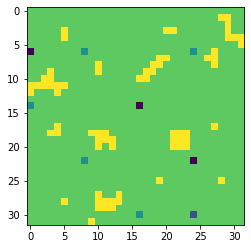

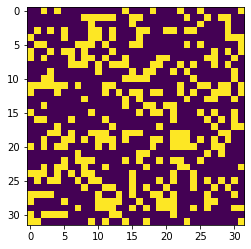

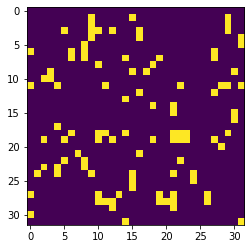

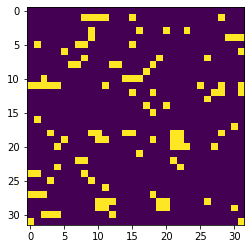

1.0


In [3]:
@cuda.jit
def zero_all(aux,ulinks,rlinks,s):
    i,j=cuda.grid(2)

    if (i<s and j<s):
        aux[i][j]=0
        ulinks[i][j]=0
        rlinks[i][j]=0

@cuda.jit
def aio(grid,aux,ip,jp,depth,s,rng_states,JB,ulinks,rlinks):
    """This performs the linking and clustering part of the code
    It serves as a direct replacement to cluster_updatep1 with
    the exception that depth and s must be such that there are enough
    the block dimensions match s>>depth
    """
    #find grid location

    stride=s>>depth
    #ioff and joff will be giving an offset
    
    x = cuda.threadIdx.x
    # Block id in a 1D grid
    y = cuda.threadIdx.y
    # Block width, i.e. number of threads per block
    bw = cuda.blockDim.x
    
    X = cuda.blockIdx.x*bw
    Y=cuda.blockIdx.y*bw
    
    #should have bw == stride

    i=(X+x+ip)%s
    j=(Y+y+jp)%s

    mynum=i*s+j
    
    #draw all the links
    if grid[i][j]==1:
            
        if grid[(i+1)%s][j]==1:
            
            n=xoroshiro128p_uniform_float32(rng_states, mynum)
            #cleaving update
            if (1-n <= 1-math.exp(-JB)):
                ulinks[i][j]=1
        if grid[i][(j+1)%s]==1:
            n=xoroshiro128p_uniform_float32(rng_states, mynum)
            #cleaving update
            if (1-n <= 1-math.exp(-JB)):
                rlinks[i][j]=1

    c1=(x+1)%stride
    c2=(y+1)%stride


    #random number not including 0
    myrand=1-xoroshiro128p_uniform_float32(rng_states, mynum)
    #case where this spot cannot be a start node
    if not (c1==0 or c1==1 or c2==0 or c2==1): 
        #setting the start node for our cluster
        if grid[i][j]==1:
            #hopefully this sets the value of aux[(X+ip)%s][(Y+jp)%s] to the max myrand number
            cuda.atomic.max(aux[(X+ip)%s], (Y+jp)%s, myrand)
            
    #in case two myrands are the same then there's some thread precidence which decides probably
    cuda.syncthreads()
    if aux[(X+ip)%s][(Y+jp)%s]== myrand:
        aux[(X+ip)%s][(Y+jp)%s]=mynum+1
    cuda.syncthreads()
        
        
    #part 2 is the graph search:
    
    #this means there were no occupied cells, all threads should end at this point if this is the case
    if aux[(X+ip)%s][(Y+jp)%s]==0:
        return
    
    #no thread work on special locations:
    done= ((c1==1 and c2==1) or (c1==0 and c2==1))
    
    
    #start the set of connected points in aux
    if grid[i][j]==1 and aux[i][j]==0 and aux[(X+ip)%s][(Y+jp)%s]==mynum+1:
        #this is a special spot in aux set to tell you the direction the cluster moves in
        aux[(X+ip)%s][(Y+jp)%s]=-int(math.floor(xoroshiro128p_uniform_float32(rng_states, mynum)*4))
        #add this spot to the movemap
        aux[i][j]=1
        done = True
        #use a special location of aux to show if done or not
        aux[(X+stride-1+ip)%s][(Y+jp)%s]=1
        
    #counter=0
    
    #now we need a synchronized while loop
    cuda.syncthreads()

    while  aux[(X+stride-1+ip)%s][(Y+jp)%s]==1:
        #counter+=1
        aux[(X+stride-1+ip)%s][(Y+jp)%s]=0
        
        cuda.syncthreads()
        
        if grid[i][j]==0:
            done=True
        if not done:
            #now we check in all legal directions:
            Linked = False
            #c1=0 means [i+1][j] is off the grid, ulinks[i][j] means (i,j) is linked with (i+1,j)
            if c1!=0 and aux[(i+1)%s][j] == 1 and ulinks[i][j]:
                Linked = True
            #c1=1 means [i-1][j] is off the grid, ulinks[i-1][j] is for (i-1,j) linked with (i,j)
            elif c1!=1 and aux[(i-1)%s][j] ==1 and ulinks[(i-1)%s][j]:
                Linked = True
            elif c2!=0 and aux[i][(j+1)%s] ==1 and rlinks[i][j]:
                Linked = True
            elif c2!=1 and aux[i][(j-1)%s] ==1 and rlinks[i][(j-1)%s]:
                Linked = True

            if Linked:
                done=True
                aux[i][j]=1
                aux[(X+stride-1+ip)%s][(Y+jp)%s]=1  
            
        cuda.syncthreads()
    
    
    #aux[(X+ip)%s][(Y+jp)%s]=counter
    
    #cases where link cannot happen or link has already happened


S1=32        
aux=cuda.to_device(np.zeros([S1,S1],dtype=np.float64))
ulinks=cuda.to_device(np.zeros([S1,S1],dtype=np.int8))
rlinks=cuda.to_device(np.zeros([S1,S1],dtype=np.int8))

grid=np.asarray(np.random.random([S1,S1])>0.7,dtype=np.float32)
#grid=np.ones([S1,S1])
rng_states = create_xoroshiro128p_states(grid.size, seed=3)
grid = cuda.to_device(grid)


max_num=int(round(np.log(S1)/np.log(2))-3)
print(max_num,"Biggest division u can do ?")


D=np.random.randint(max_num-1,max_num+1)
print(D)
D=2

threadsperblock = (S1>>D, S1>>D)#should end up a multiple of 32 I think
blockspergrid = (2**D, 2**D)

zero_all[blockspergrid, threadsperblock](aux,ulinks,rlinks,S1)

print(threadsperblock,blockspergrid)

ip=np.random.randint(S1//2)
jp=np.random.randint(S1//2)
print(ip,jp)

aio[blockspergrid, threadsperblock](grid,aux,ip,jp,D,S1,rng_states,1000,ulinks,rlinks)

plt.imshow(aux)
plt.show()
plt.imshow(grid)
plt.show()
plt.imshow(ulinks)
plt.show()
plt.imshow(rlinks)
plt.show()
print(np.max(aux))

In [5]:
@cuda.jit
def full_update(grid,aux,ip,jp,depth,s,rng_states,JB,ulinks,rlinks):
    """Require: block width == s>>depth
    This function:
    1. Breaks the grid in half depth times 
    (Ex A 128x128 grid with depth 3 breaks it into 16x16 size blocks)
    2. Draws links between particles according to p=1-math.exp(-JB)
    3. Choose a starting particle in each block and follow the links to form a cluster
    4. Validate the cluster so it: 
        a) Does not touch the block border and
        b) Moving the cluster does not cause an overlap
    5. Apply the cluster moves for each block if they are valid
    6. Replaces aio, cluster_updatep2, cluster_updatep3
    """
    #Initial Setup

    stride=s>>depth
    #ioff and joff will be giving an offset
    
    # Block id in a 2D grid
    x = cuda.threadIdx.x
    
    y = cuda.threadIdx.y
    # Block width, i.e. number of threads per block
    bw = cuda.blockDim.x
    
    X = cuda.blockIdx.x*bw
    Y=cuda.blockIdx.y*bw
    
    #should have bw == stride

    #shifting the lines separating blocks
    i=(X+x+ip)%s
    j=(Y+y+jp)%s
    
    aux[i][j]=0
    ulinks[i][j]=0
    rlinks[i][j]=0
    cuda.syncthreads()
    
    mynum=i*s+j
    
    #draw all the links
    if grid[i][j]==1:
            
        if grid[(i+1)%s][j]==1:
            
            n=xoroshiro128p_uniform_float32(rng_states, mynum)
            #cleaving update
            if (1-n <= 1-math.exp(-JB)):
                ulinks[i][j]=1
        if grid[i][(j+1)%s]==1:
            n=xoroshiro128p_uniform_float32(rng_states, mynum)
            #cleaving update
            if (1-n <= 1-math.exp(-JB)):
                rlinks[i][j]=1

    c1=(x+1)%stride
    c2=(y+1)%stride


    #random number not including 0
    myrand=1-xoroshiro128p_uniform_float32(rng_states, mynum)
    #case where this spot cannot be a start node
    if not (c1==0 or c1==1 or c2==0 or c2==1): 
        #setting the start node for our cluster
        if grid[i][j]==1:
            #Set bid for this point to be the starting point
            cuda.atomic.max(aux[(X+ip)%s], (Y+jp)%s, myrand)
            
    #in case two myrands are the same then there's some thread precidence which decides probably
    cuda.syncthreads()
    #Choose the position with the maximum bid
    if aux[(X+ip)%s][(Y+jp)%s] == myrand:
        aux[(X+ip)%s][(Y+jp)%s]=mynum+1
    cuda.syncthreads()
        
        
    #Next is the graph search:
    
    #this means there were no occupied cells, all threads should end at this point if this is the case
    if aux[(X+ip)%s][(Y+jp)%s]==0:
        return
    
    #no thread work on special locations:
    done= ((c1==1 and c2==1) or (c1==0 and c2==1))
    
    
    #start the set of connected points in aux
    if grid[i][j]==1 and aux[i][j]==0 and aux[(X+ip)%s][(Y+jp)%s]==mynum+1:
        #this is a special spot in aux set to tell you the direction the cluster moves in
        aux[(X+ip)%s][(Y+jp)%s]=-int(math.floor(xoroshiro128p_uniform_float32(rng_states, mynum)*4))
        #add this spot to the movemap
        aux[i][j]=1
        done = True
        #use a special location of aux to show if done or not
        aux[(X+stride-1+ip)%s][(Y+jp)%s]=1
        
    #counter=0
    
    #now we need a synchronized while loop
    cuda.syncthreads()

    while  aux[(X+stride-1+ip)%s][(Y+jp)%s]==1:
        cuda.syncthreads()
        #counter+=1
        aux[(X+stride-1+ip)%s][(Y+jp)%s]=0
        
        cuda.syncthreads()
        
        if grid[i][j]==0:
            done=True
        if not done:
            #now we check in all legal directions:
            Linked = False
            #c1=0 means [i+1][j] is off the grid, ulinks[i][j] means (i,j) is linked with (i+1,j)
            if c1!=0 and aux[(i+1)%s][j] == 1 and ulinks[i][j]:
                Linked = True
            #c1=1 means [i-1][j] is off the grid, ulinks[i-1][j] is for (i-1,j) linked with (i,j)
            elif c1!=1 and aux[(i-1)%s][j] ==1 and ulinks[(i-1)%s][j]:
                Linked = True
            elif c2!=0 and aux[i][(j+1)%s] ==1 and rlinks[i][j]:
                Linked = True
            elif c2!=1 and aux[i][(j-1)%s] ==1 and rlinks[i][(j-1)%s]:
                Linked = True

            if Linked:
                done=True
                aux[i][j]=1
                aux[(X+stride-1+ip)%s][(Y+jp)%s]=1  
            
        cuda.syncthreads()
    
    cuda.syncthreads()
    
    #Now we validate
    
    direction = -int(aux[(X+ip)%s][(Y+jp)%s])
    #bit stuff outputs [-1 0], [0 -1], [1 0], [1 1]
    b1=(direction>>1)
    b2=(direction&1)
    #infront in the direction of motion
    ni=i+(1-b2)*(2*b1-1)
    nj=j+b2*(2*b1-1)
    #behind in direction of motion
    bi=i-(1-b2)*(2*b1-1)
    bj=j-b2*(2*b1-1)
    
    #detecting collisions and illegal links which stop the update
        
    #formed a link to an element on the border
    if (c1==0 or c1==1 or c2==0 or c2==1) and aux[i][j]>0:
        #this index indicates a fail to update
        #this is the c1=0 c2=1 position
        aux[(X+stride-1+ip)%s][(Y+jp)%s]=-10
    else:
        #detect if there is a collision
        if aux[i][j]>0 and aux[ni%s][nj%s]==0 and grid[ni%s][nj%s]==1:
        #this cell moves     other cell doesnt      other cell is occupied
            aux[(X+stride-1+ip)%s][(Y+jp)%s]= -10#-1-direction
        #THE CASE WHERE IT MOVES ONTO A BORDER???????? 
        cn1=(ni+1-ip)%stride
        cn2=(nj+1-jp)%stride
        if (cn1==0 or cn1==1 or cn2==0 or cn2==1) and aux[i][j]>0:
            #would be moved onto a border which is a no-go
            aux[(X+stride-1+ip)%s][(Y+jp)%s]=-10

    cuda.syncthreads()
    #moving the particle
    if aux[(X+stride-1+ip)%s][(Y+jp)%s]==0 and aux[i][j]>0:
        #if nothing in front put something there
        if aux[ni%s][nj%s]==0:
            grid[ni%s][nj%s]=1
        #if nothing behind remove self here
        if aux[bi%s][bj%s]==0:
            grid[i][j]=0

In [35]:
@cuda.jit
def schmix_cluster(grid,JB,ip,jp,s,rng_states):
    """This Breaks the cluster into 4x4 grids and instead of doing
    a cleaving update or single particle moves, it takes the inner
    2x2 area, evaluates the bonds, chooses a random permutation of
    cell ordering (hard coded in), re-evaluates energies, then
    accepts the move with boltzmann probability."""

    y,x=cuda.grid(2)
    
    if not (y<s//4 and x<s//4):
        return
    
    mynum=y*s+x
    
    i=y*4+ip
    j=x*4+jp

    #//choose the permutation
    mutate = (math.floor(xoroshiro128p_uniform_float32(rng_states, mynum)* 23))+1
    #if mutate>23: return INCLUDED BELOW
    #//evaluate current bonds
    
    #left edge
    a21=grid[(i+1)%s][j%s]
    a31=grid[(i+2)%s][j%s]
    #bottom edge
    a42=grid[(i+3)%s][(j+1)%s]
    a43=grid[(i+3)%s][(j+2)%s]
    #top edge
    a12=grid[i%s][(j+1)%s]
    a13=grid[i%s][(j+2)%s]
    #right edge
    a24=grid[(i+1)%s][(j+3)%s]
    a34=grid[(i+2)%s][(j+3)%s]
     
    #inner square
    a22=grid[(i+1)%s][(j+1)%s]
    a23=grid[(i+1)%s][(j+2)%s]
    a32=grid[(i+2)%s][(j+1)%s]
    a33=grid[(i+2)%s][(j+2)%s]
     
    
    #//left and bottom
    oldbonds = a21*a22+a31*a32+a42*a32+a43*a33
    #//right and top
    oldbonds+= a22*a12+a23*a13+a23*a24+a33*a34
    #//inner
    oldbonds+= a22*a23+a22*a32+a33*a32+a33*a23
    
    
    #this rearranges the particles to a different part of the inner square
    #This code was generated programatically
    if mutate   == 0:return#[0, 1, 2, 3]
    elif mutate == 1:c22,c23,c32,c33=a22,a23,a33,a32#[0, 1, 3, 2]
    elif mutate == 2:c22,c23,c32,c33=a22,a32,a23,a33#[0, 2, 1, 3]
    elif mutate == 3:c22,c23,c32,c33=a22,a32,a33,a23#[0, 2, 3, 1]
    elif mutate == 4:c22,c23,c32,c33=a22,a33,a23,a32#[0, 3, 1, 2]
    elif mutate == 5:c22,c23,c32,c33=a22,a33,a32,a23#[0, 3, 2, 1]
    elif mutate == 6:c22,c23,c32,c33=a23,a22,a32,a33#[1, 0, 2, 3]
    elif mutate == 7:c22,c23,c32,c33=a23,a22,a33,a32#[1, 0, 3, 2]
    elif mutate == 8:c22,c23,c32,c33=a23,a32,a22,a33#[1, 2, 0, 3]
    elif mutate == 9:c22,c23,c32,c33=a23,a32,a33,a22#[1, 2, 3, 0]
    elif mutate == 10:c22,c23,c32,c33=a23,a33,a22,a32#[1, 3, 0, 2]
    elif mutate == 11:c22,c23,c32,c33=a23,a33,a32,a22#[1, 3, 2, 0]
    elif mutate == 12:c22,c23,c32,c33=a32,a22,a23,a33#[2, 0, 1, 3]
    elif mutate == 13:c22,c23,c32,c33=a32,a22,a33,a23#[2, 0, 3, 1]
    elif mutate == 14:c22,c23,c32,c33=a32,a23,a22,a33#[2, 1, 0, 3]
    elif mutate == 15:c22,c23,c32,c33=a32,a23,a33,a22#[2, 1, 3, 0]
    elif mutate == 16:c22,c23,c32,c33=a32,a33,a22,a23#[2, 3, 0, 1]
    elif mutate == 17:c22,c23,c32,c33=a32,a33,a23,a22#[2, 3, 1, 0]
    elif mutate == 18:c22,c23,c32,c33=a33,a22,a23,a32#[3, 0, 1, 2]
    elif mutate == 19:c22,c23,c32,c33=a33,a22,a32,a23#[3, 0, 2, 1]
    elif mutate == 20:c22,c23,c32,c33=a33,a23,a22,a32#[3, 1, 0, 2]
    elif mutate == 21:c22,c23,c32,c33=a33,a23,a32,a22#[3, 1, 2, 0]
    elif mutate == 22:c22,c23,c32,c33=a33,a32,a22,a23#[3, 2, 0, 1]
    elif mutate == 23:c22,c23,c32,c33=a33,a32,a23,a22#[3, 2, 1, 0]
    else:return

    #//re-evaluate all the bonds
    newbonds = a21*c22+a31*c32+a42*c32+a43*c33
    #//right and top
    newbonds+= c22*a12+c23*a13+c23*a24+c33*a34
    #//inner
    newbonds+= c22*c23+c22*c32+c33*c32+c33*c23
    
    #flipped sign because bonds reduce energy
    delta = oldbonds-newbonds
    #//update rule for MCMC
    #//I have very little trust in the GPU Math.random function
    
    n=xoroshiro128p_uniform_float32(rng_states, mynum)
    if(delta < 0 or 1.0-n<math.exp(-JB*delta)):
        #apply the permutation on the inner square with boltzmann probability
        
        grid[(i+1)%s][(j+1)%s]=c22
        grid[(i+1)%s][(j+2)%s]=c23
        grid[(i+2)%s][(j+1)%s]=c32
        grid[(i+2)%s][(j+2)%s]=c33

In [7]:
@cuda.jit
def init_structures(grid,stack,aux,s,ip,jp,ulinks,rlinks,valid,JB,rng_states):
    """This initializes the stack with the seed particle, draws all the links to be used in clustering,
    and resets the auxilliary arrays"""
    #find grid location
    i,j=cuda.grid(2)
    #ip and jp will be giving an offset
    if not (i<s and j<s):return
    #unlink all the links so we are ready for the next update
    ulinks[i][j]=0
    rlinks[i][j]=0
    #Initialize the stack with the start node
    mynum=((i+ip)%s)*s+(j+jp)%s
    if grid[(i+ip)%s][(j+jp)%s]==1:
        stack[-1]=mynum+1
        stack[0]=1
        #if the stack is nonempty for now the cluster update is valid
        valid[0]=1

    mynum=i*s+j
    #drawing links:
    if grid[i][j]==1:
        if grid[(i+1)%s][j]==1:
            n=xoroshiro128p_uniform_float32(rng_states, mynum)
            #cleaving update
            if (1-n <= 1-math.exp(-JB)):
                ulinks[i][j]=1
        if grid[i][(j+1)%s]==1:
            n=xoroshiro128p_uniform_float32(rng_states, mynum)
            #cleaving update
            if (1-n <= 1-math.exp(-JB)):
                rlinks[i][j]=1
    #reset aux to zero
    aux[i][j]=0
    

@cuda.jit
def stack_clustering(grid,aux,stack,ulinks,rlinks,center,s):
    """Form the entire cluster using rlinks and ulinks
    by using a global stack to keep track of active search
    nodes."""
    x = cuda.threadIdx.x
    center[0]=stack[-1]
    while stack[0]>0:
        cuda.syncthreads()
        mysize = cuda.atomic.add(stack, 0, -1)
        #class add(ary, idx, val)
        #Perform atomic ary[idx] += val. Supported on int32, float32, and float64 operands only.
        #Returns the old value at the index location as if it is loaded atomically.
        ip1=jp1=im1=jm1=0
        if mysize>0:
            gridnum = stack[-mysize]-1
            i=gridnum//s
            j=gridnum%s
            if not (grid[i][j]==0):
                oldauxval = cuda.atomic.max(aux[i],j,1)
                if oldauxval==0:
                    #ulinks[i][j] means (i,j) is linked with (i+1,j)
                    if grid[(i+1)%s][j]==1 and aux[(i+1)%s][j]==0 and ulinks[i][j]: 
                        ip1= ((i+1)%s)*s+j+1
                    #ulinks[i-1][j] is for (i-1,j) linked with (i,j)
                    if grid[(i-1)%s][j]==1 and aux[(i-1)%s][j]==0 and ulinks[(i-1)%s][j]:
                        im1= ((i-1)%s)*s+j+1
                    if grid[i][(j+1)%s]==1 and aux[i][(j+1)%s]==0 and rlinks[i][j]:
                        jp1=i*s+(j+1)%s+1
                    if grid[i][(j-1)%s]==1 and aux[i][(j-1)%s]==0 and rlinks[i][(j-1)%s]:
                        jm1=i*s+(j-1)%s+1
        
        cuda.syncthreads()
        if mysize<=0:
            stack[0]=0
        cuda.syncthreads()
        #now we do all the stack adding
        if ip1>0:
            mysize = cuda.atomic.add(stack, 0, 1)
            stack[-mysize-1]=ip1
        if im1>0:
            mysize = cuda.atomic.add(stack, 0, 1)
            stack[-mysize-1]=im1
        if jp1>0:
            mysize = cuda.atomic.add(stack, 0, 1)
            stack[-mysize-1]=jp1
        if jm1>0:
            mysize = cuda.atomic.add(stack, 0, 1)
            stack[-mysize-1]=jm1
        cuda.syncthreads()
      

@cuda.jit
def validate_update(grid,aux,s,valid,direction,center):
    i,j=cuda.grid(2)
    if (i<s and j<s and valid[0]==1):
        if direction>3:
            ci=(center[0]-1)//s
            cj=(center[0]-1)%s
            
            ni=(-(j-cj)+ci)%s
            nj=((i-ci)+cj)%s
            bi=((j-cj)+ci)%s
            bj=(-(i-ci)+cj)%s
            if direction==5:
                ni,bi=bi,ni
                nj,bj=bj,nj
        else:
            #bit stuff outputs [-1 0], [0 -1], [1 0], [1 1]
            b1=(direction>>1)
            b2=(direction&1)
            #infront in the direction of motion
            ni=i+(1-b2)*(2*b1-1)
            nj=j+b2*(2*b1-1)
            #behind in direction of motion
            bi=i-(1-b2)*(2*b1-1)
            bj=j-b2*(2*b1-1)

        #detect if there is a collision
        if aux[i][j]>0 and aux[ni%s][nj%s]==0 and grid[ni%s][nj%s]==1:
        #this cell moves     other cell doesnt      other cell is occupied
            valid[0]=0


@cuda.jit
def perform_update(grid,aux,s,valid,direction,center,ulinks,rlinks):
    i,j=cuda.grid(2)
    
    #moving the particle
    if (i<s and j<s and valid[0]==1):
        if direction>3:
            ci=(center[0]-1)//s
            cj=(center[0]-1)%s
            
            ni=(-(j-cj)+ci)%s
            nj=((i-ci)+cj)%s
            bi=((j-cj)+ci)%s
            bj=(-(i-ci)+cj)%s
            if direction==5:
                ni,bi=bi,ni
                nj,bj=bj,nj
        else:
            b1=(direction>>1)
            b2=(direction&1)
            #infront in the direction of motion
            ni=i+(1-b2)*(2*b1-1)
            nj=j+b2*(2*b1-1)
            #behind in direction of motion
            bi=i-(1-b2)*(2*b1-1)
            bj=j-b2*(2*b1-1)
            
        if aux[i][j]>0:
            #if nothing in front put something there
            if aux[ni%s][nj%s]==0:
                grid[ni%s][nj%s]=1
            #if nothing behind remove self here
            if aux[bi%s][bj%s]==0:
                grid[i][j]=0
                
                

In [8]:
@cuda.jit
def multi_stack_clustering(grid,aux,stack,ulinks,rlinks,center,threadstacks,s,ITER):
    """Form the entire cluster using rlinks and ulinks
    by using a global stack to keep track of  all
    unallocated active search nodes, as well as a 
    small stack for each thread to encourage
    independent work."""
    x = cuda.threadIdx.x
    nthreads,stacksize=threadstacks.shape
    counter=0
    center[0]=stack[-1]
    while stack[0]>0:
        cuda.syncthreads()
        mysize=0
        if counter>0:
            gridnum = threadstacks[x][counter-1]-1
            counter-=1
        else:
            mysize = cuda.atomic.add(stack, 0, -1)
            #class add(ary, idx, val)
            #Perform atomic ary[idx] += val. Supported on int32, float32, and float64 operands only.
            #Returns the old value at the index location as if it is loaded atomically.
            if mysize>0:
                gridnum = stack[-mysize]-1
                
        if counter>0 or mysize>0:
            i=gridnum//s
            j=gridnum%s
            for indx in range(ITER):
                if not (grid[i][j]==0):
                    oldauxval = cuda.atomic.max(aux[i],j,1)
                    if oldauxval==0:
                        #ulinks[i][j] means (i,j) is linked with (i+1,j)
                        if grid[(i+1)%s][j]==1 and aux[(i+1)%s][j]==0 and ulinks[i][j]: 
                            threadstacks[x][counter]= ((i+1)%s)*s+j+1
                            counter+=1
                        #ulinks[i-1][j] is for (i-1,j) linked with (i,j)
                        if grid[(i-1)%s][j]==1 and aux[(i-1)%s][j]==0 and ulinks[(i-1)%s][j]:
                            threadstacks[x][counter]= ((i-1)%s)*s+j+1
                            counter+=1
                        if grid[i][(j+1)%s]==1 and aux[i][(j+1)%s]==0 and rlinks[i][j]:
                            threadstacks[x][counter]=i*s+(j+1)%s+1
                            counter+=1
                        if grid[i][(j-1)%s]==1 and aux[i][(j-1)%s]==0 and rlinks[i][(j-1)%s]:
                            threadstacks[x][counter]=i*s+(j-1)%s+1
                            counter+=1
                if counter>0  and (stacksize-counter)>4:
                    if indx<ITER-1:
                        gridnum = threadstacks[x][counter-1]-1
                        counter-=1
                        i=gridnum//s
                        j=gridnum%s
                else:
                    break
        
        cuda.syncthreads()
        if mysize<=0:
            stack[0]=0
        cuda.syncthreads()
        #now we do all the stack adding
        if stack[0]==0 or (stacksize-counter)<4:
            while counter>0:
                mysize = cuda.atomic.add(stack, 0, 1)
                stack[-mysize-1]=threadstacks[x][counter-1]
                counter-=1
        cuda.syncthreads()

In [10]:
##################################################
@jit(nopython=True)
def clustering(x,y,grid,xarr,yarr,p):
        sx,sy=grid.shape
        #it's important to set the grid area to 0 initially so
        #there is no infinite recursion
        grid[x,y]=0
        xarr+=[x]
        yarr+=[y]
        #check to move the cluster in each direction
        if grid[(x+1)%sx,y]==1 and np.random.random()<=p:
            clustering((x+1)%sx,y,grid,xarr,yarr,p)
        if grid[(x-1)%sx,y]==1 and np.random.random()<=p:
            clustering((x-1)%sx,y,grid,xarr,yarr,p)
        if grid[x,(y+1)%sy]==1 and np.random.random()<=p:
            clustering(x,(y+1)%sy,grid,xarr,yarr,p)
        if grid[x,(y-1)%sy]==1 and np.random.random()<=p:
            clustering(x,(y-1)%sy,grid,xarr,yarr,p)

@jit(nopython=True)
def make_cluster(x,y,grid,d,p):
    xarr=[0][1:]
    yarr=[0][1:]
    if grid[x,y]==1:
        clustering(x,y,grid,xarr,yarr,p)
    xarr2=np.array(xarr)
    yarr2=np.array(yarr)
    for i in range(xarr2.size):
        grid[xarr2[i],yarr2[i]]=1
    return xarr2,yarr2


@jit(nopython=True) 
def CPU_Update(grid,JB):
    """Update entire clusters following detailed balance.
    This is the cpu version of the pipeline:
    Init_structures()
    Stack_clustering() (or multistack)
    validate_update()
    perform_update()
        """

    #The equation is: p = max(0,1 − exp[BEc(i,j)−BEI(i,j)])
    #here Ec = -J and EI=0
    #Note this is a ficticious hamiltonian since it considers an overlap
    #to have zero energy whereas in the real one an overlap has infinite
    p=max(0, 1-np.exp(-JB))
    #Now we upper bound p to the largest floating point less than 1
    #This number is 0.9999999999999999
    #p = min(p,1-np.exp(-37))
    
    #print(p)
    sx,sy=grid.shape#grid2.shape
    #going to copy the grid here even though redundant
    #grid=grid2.copy()
    
    pos=[(x,y) for x in range(sx) for y in range(sy) if grid[x,y]==1]

    i=np.random.randint(len(pos))
    x,y=pos[i]
    action=np.random.randint(6)
    xs,ys=make_cluster(x,y,grid,action,p)
    for i in range(xs.size):
        grid[xs[i],ys[i]]=0
    #cluster translation
    if action==0:
        rx,ry=(xs+1)%sx,ys
    elif action==1:
        rx,ry=(xs-1)%sx,ys
    elif action==2:
        rx,ry=xs,(ys+1)%sy
    elif action==3:
        rx,ry=xs,(ys-1)%sy
    elif action == 4:
        #apply rotation to coordinates
        rx=(-(ys-y)+x)%sx
        ry=((xs-x)+y)%sy
    elif action == 5:
        #apply rotation to coordinates
        rx=((ys-y)+x)%sx
        ry=(-(xs-x)+y)%sy
    s=0
    for i in range(rx.size):
            s+=grid[rx[i],ry[i]]
    if s!=0:
        for i in range(xs.size):
            grid[xs[i],ys[i]]=1
        return grid
    for i in range(xs.size):
        grid[rx[i],ry[i]]=1
    return grid
##################################################

In [71]:
@cuda.jit
def upscale(inarr,outarr):
    i,j=cuda.grid(2)
    iscale=outarr.shape[0]//inarr.shape[0]
    jscale=outarr.shape[1]//inarr.shape[1]
    outarr[i][j]=inarr[i//iscale][j//jscale]
class Render(Thread):
    def __init__(self, globalmem, canvas,dim=[512,512]):
        self.upscaled=np.zeros(dim)
        self.threads=(16,16)
        self.blocks=(int(np.ceil(dim[0] / 16)),int(np.ceil(dim[1] / 16)))
        self.grid_global_mem = globalmem
        self.canvas = canvas
        self.isalive=True
        super(Render, self).__init__()
    def run(self):
        while self.isalive:
            upscale[self.blocks,self.threads](self.grid_global_mem,self.upscaled)
            gridf=self.upscaled
            blue_channel = (1-gridf)*255
            red_channel = gridf*255
            green_channel = np.zeros_like(gridf)
            image_data = np.stack((red_channel, green_channel, blue_channel), axis=2)
            self.canvas.put_image_data(image_data, 0, 0)
            time.sleep(0.01)

class Cluster2(Thread):
    def __init__(self, N):
        self.N=N
        self.grid=np.asarray(np.random.random([N,N])>0.8,dtype=np.int32)
        self.threadsperblock = (16, 16)#should end up a multiple of 32 I think
        blockspergrid_x = int(np.ceil(self.grid.shape[0] / self.threadsperblock[0]))
        blockspergrid_y = int(np.ceil(self.grid.shape[1] / self.threadsperblock[1]))
        self.blockspergrid = (blockspergrid_x, blockspergrid_y)
        self.isalive=True
        self.rng_states = create_xoroshiro128p_states(self.grid.size, seed=1)
        self.grid_global_mem = cuda.to_device(self.grid)
        self.JB=5
        self.mew=0
        self.aux=cuda.to_device(np.zeros([self.N,self.N],dtype=np.float64))
        self.ulinks=cuda.to_device(np.zeros([self.N,self.N],dtype=np.int8))
        self.rlinks=cuda.to_device(np.zeros([self.N,self.N],dtype=np.int8))
        
        super(Cluster2, self).__init__()
    def fps(self):
        iold = self.index
        time.sleep(1)
        return self.index-iold
    def run(self):
        ulinks=self.ulinks
        rlinks=self.rlinks
        aux=self.aux
        grid=self.grid_global_mem
        S1=self.N
        self.index=0
        max_num=int(round(np.log(S1)/np.log(2))-3)
        print(max_num)
        valid=cuda.to_device(np.zeros([1],dtype=np.int8))
        center=cuda.to_device(np.zeros([1],dtype=np.int64))
        stack=cuda.to_device(np.zeros([S1*S1*4],dtype=np.int64))
        multistack=cuda.to_device(np.zeros([512,128],dtype=np.int64))
        smallblock=(self.blockspergrid[0]//4,self.blockspergrid[1]//4)
        print(smallblock, self.threadsperblock)
        while self.isalive:
            
            self.index+=1
            
            D=np.random.randint(max_num-1,max_num+1)
            #D=np.random.randint(0,max_num+1)
            threadsperblock = (S1>>D, S1>>D)#should end up a multiple of 32 I think
            blockspergrid = (2**D, 2**D)
            
            #ip=jp=0
            n=np.random.random()
            
            if n<0.2:
                ip=np.random.randint(S1//2)
                jp=np.random.randint(S1//2)
                full_update[blockspergrid, threadsperblock](grid,aux,ip,jp,D,S1,self.rng_states,self.JB,ulinks,rlinks)
            elif n<0.8:
                ip=np.random.randint(4)
                jp=np.random.randint(4)
                #ip=jp=0
                schmix_cluster[smallblock, self.threadsperblock](grid,self.JB,ip,jp,S1,self.rng_states)
                #time.sleep(0.1)
            elif True:
                ip=np.random.randint(S1)
                jp=np.random.randint(S1)
                direction=np.random.randint(6)
                
                init_structures[self.blockspergrid, self.threadsperblock](grid,stack,aux,S1,ip,jp,ulinks,rlinks,valid,self.JB,self.rng_states)
                
                #single_threaded_clustering[1,512](grid,aux,stack,ulinks,rlinks,center,S1) 
                
                #stack_clustering[1,512](grid,aux,stack,ulinks,rlinks,center,S1)                
                
                multi_stack_clustering[1,512](grid,aux,stack,ulinks,rlinks,center,multistack,S1,8)
                
                validate_update[self.blockspergrid, self.threadsperblock](grid,aux,S1,valid,direction,center)
                perform_update[self.blockspergrid, self.threadsperblock](grid,aux,S1,valid,direction,center,ulinks,rlinks)
                
            elif False:
                ip=np.random.randint(S1//2)
                jp=np.random.randint(S1//2)
                
                zero_all[self.blockspergrid, self.threadsperblock](aux,ulinks,rlinks,S1)

                aio[blockspergrid, threadsperblock](grid,aux,ip,jp,D,S1,self.rng_states,self.JB,ulinks,rlinks)

                #cluster_updatep1[self.blockspergrid, self.threadsperblock](grid,aux,ip,jp,D,S1,self.rng_states,self.JB)
                cluster_updatep2[self.blockspergrid, self.threadsperblock](grid,aux,ip,jp,D,S1,self.rng_states,self.JB)
                cluster_updatep3[self.blockspergrid, self.threadsperblock](grid,aux,ip,jp,D,S1,self.rng_states,self.JB)
            else:
                if self.index==1:
                    self.grid_global_mem=np.asarray(self.grid_global_mem.copy_to_host())
                    print('swapped')
                CPU_Update(self.grid_global_mem,self.JB)
cleaner.hard_reset()

model = Cluster2(256)
model.grid=np.asarray(np.random.random(model.grid.shape)>0.8,dtype=np.int32)#0.878
model.grid_global_mem = cuda.to_device(model.grid)
print(model.grid_global_mem.size)
print(np.sum(model.grid_global_mem.copy_to_host()))
model.JB=6
print(model.blockspergrid)
print(model.threadsperblock)
canvas = Canvas(width=512, height=512)
rend = Render(model.grid_global_mem,canvas)
cleaner.add(model,rend)
#model.debug()
#1/0
model.start()
time.sleep(1)
rend.grid_global_mem=model.grid_global_mem
rend.start()
canvas

65536
13184
(16, 16)
(16, 16)
5
(4, 4) (16, 16)


Canvas(height=512, width=512)

In [73]:
model.JB=2
print(model.fps())
np.sum(model.grid_global_mem.copy_to_host())

1941


13184

In [52]:
class Visualizer(Thread):
    def __init__(self, N):
        self.N=N
        self.grid=np.asarray(np.random.random([N,N])>0.8,dtype=np.int32)
        self.threadsperblock = (16, 16)#should end up a multiple of 32 I think
        blockspergrid_x = int(np.ceil(self.grid.shape[0] / self.threadsperblock[0]))
        blockspergrid_y = int(np.ceil(self.grid.shape[1] / self.threadsperblock[1]))
        self.blockspergrid = (blockspergrid_x, blockspergrid_y)
        self.isalive=True
        self.rng_states = create_xoroshiro128p_states(self.grid.size, seed=1)
        self.grid_global_mem = cuda.to_device(self.grid)
        self.JB=5
        self.mew=0
        self.aux=cuda.to_device(np.zeros([self.N,self.N],dtype=np.float64))
        self.ulinks=cuda.to_device(np.zeros([self.N,self.N],dtype=np.int8))
        self.rlinks=cuda.to_device(np.zeros([self.N,self.N],dtype=np.int8))

        super(Visualizer, self).__init__()
    def fps(self):
        iold = self.index
        time.sleep(1)
        return self.index-iold
    def run(self):
        ulinks=self.ulinks
        rlinks=self.rlinks
        aux=self.aux
        grid=self.grid_global_mem
        S1=self.N
        self.index=0
        max_num=int(round(np.log(S1)/np.log(2))-3)
        print(max_num)
        valid=cuda.to_device(np.zeros([1],dtype=np.int8))
        center=cuda.to_device(np.zeros([1],dtype=np.int64))
        stack=cuda.to_device(np.zeros([S1*S1*4],dtype=np.int64))
        multistack=cuda.to_device(np.zeros([512,128],dtype=np.int64))
        smallblock=(self.blockspergrid[0]//4,self.blockspergrid[1]//4)
        print(smallblock, self.threadsperblock)
        frames_=0
        folder="movie"
        while self.isalive and self.index<5300:
            
            self.index+=1
            
            D=np.random.randint(max_num-1,max_num+1)
            #D=np.random.randint(0,max_num+1)
            threadsperblock = (S1>>D, S1>>D)#should end up a multiple of 32 I think
            blockspergrid = (2**D, 2**D)
            
            #ip=jp=0
            n=np.random.random()
            if self.index<5000:
                if n<0.2:
                    ip=np.random.randint(S1//2)
                    jp=np.random.randint(S1//2)
                    full_update[blockspergrid, threadsperblock](grid,aux,ip,jp,D,S1,self.rng_states,self.JB,ulinks,rlinks)
                elif n<0.8:
                    ip=np.random.randint(4)
                    jp=np.random.randint(4)
                    #ip=jp=0
                    schmix_cluster[smallblock, self.threadsperblock](grid,self.JB,ip,jp,S1,self.rng_states)
                    #time.sleep(0.1)
                elif True:
                    ip=np.random.randint(S1)
                    jp=np.random.randint(S1)
                    direction=np.random.randint(6)

                    init_structures[self.blockspergrid, self.threadsperblock](grid,stack,aux,S1,ip,jp,ulinks,rlinks,valid,self.JB,self.rng_states)

                    #single_threaded_clustering[1,512](grid,aux,stack,ulinks,rlinks,center,S1) 

                    #stack_clustering[1,512](grid,aux,stack,ulinks,rlinks,center,S1)                

                    multi_stack_clustering[1,512](grid,aux,stack,ulinks,rlinks,center,multistack,S1,8)

                    validate_update[self.blockspergrid, self.threadsperblock](grid,aux,S1,valid,direction,center)
                    perform_update[self.blockspergrid, self.threadsperblock](grid,aux,S1,valid,direction,center,ulinks,rlinks)
            elif n<0.3:
                ip=np.random.randint(S1)
                jp=np.random.randint(S1)
                direction=np.random.randint(6)

                init_structures[self.blockspergrid, self.threadsperblock](grid,stack,aux,S1,ip,jp,ulinks,rlinks,valid,self.JB,self.rng_states)
                #single_threaded_clustering[1,512](grid,aux,stack,ulinks,rlinks,center,S1) 
                #stack_clustering[1,512](grid,aux,stack,ulinks,rlinks,center,S1)                
                multi_stack_clustering[1,512](grid,aux,stack,ulinks,rlinks,center,multistack,S1,8)


                gridi= self.grid_global_mem.copy_to_host()
                self.upscale=3
                gridf=np.zeros([a*self.upscale for a in gridi.shape])
                for i in range(self.upscale):
                    for j in range(self.upscale):
                        gridf[i::self.upscale,j::self.upscale]=gridi*2


                for i in range(S1):
                    for j in range(S1):
                        if aux[i][j]>0:
                            gridf[i*3:i*3+3,j*3:j*3+3]=6#aux[i][j]*6
                
                CNTRI=(center[0]-1)//S1
                CNTRJ=(center[0]-1)%S1
                gridf[3*CNTRI:3*CNTRI+3,3*CNTRJ:3*CNTRJ+3]=7
                #grid is now upscaled to 3x3
                #draw the gridlines and links
                K1=gridf.shape[0]

                for i in range(S1):
                    for j in range(S1):
                        if ulinks[i][j]:
                            gridf[(3*i+2)%K1][(3*j+1)%K1]=1
                            gridf[(3*i+3)%K1][(3*j+1)%K1]=1
                        if rlinks[i][j]:
                            gridf[(3*i+1)%K1][(3*j+2)%K1]=1
                            gridf[(3*i+1)%K1][(3*j+3)%K1]=1
                            
                plt.imshow(gridf,vmin=-1,vmax=7)
                plt.axis('off')
                string = "0"*(7-len(str(frames_)))+str(frames_)
                plt.savefig(folder+"/frame%s.png"%string,bbox_inches='tight', pad_inches=0,transparent=True)
                plt.clf()
                frames_+=1
                
                validate_update[self.blockspergrid, self.threadsperblock](grid,aux,S1,valid,direction,center)
                perform_update[self.blockspergrid, self.threadsperblock](grid,aux,S1,valid,direction,center,ulinks,rlinks)
            elif n<0.7:
                ip=np.random.randint(4)
                jp=np.random.randint(4)
                
                gridi= self.grid_global_mem.copy_to_host()
                
                mulmap=np.ones_like(gridi)*2
                for i in range(gridi.shape[0]):
                    for j in range(gridi.shape[1]):
                        if ((i+1-ip)%4 in [2,3] and (j+1-jp)%4 in [2,3]):
                            mulmap[i][j]+=2
                    

                
                self.upscale=3
                gridf=np.zeros([a*self.upscale for a in gridi.shape])
                for i in range(self.upscale):
                    for j in range(self.upscale):
                        gridf[i::self.upscale,j::self.upscale]=gridi*2*mulmap
                
                #grid is now upscaled to 3x3
                #draw the gridlines and links
                gridspots=4*3
                for i in range(gridf.shape[0]):
                    for j in range(gridf.shape[1]):
                        if ((i+1-ip*3)%gridspots in [0,1] or (j+1-jp*3)%gridspots in [0,1]):
                            gridf[i][j]=-1
                            
                plt.imshow(gridf,vmin=-1,vmax=6)
                plt.axis('off')
                string = "0"*(7-len(str(frames_)))+str(frames_)
                plt.savefig(folder+"/frame%s.png"%string,bbox_inches='tight', pad_inches=0,transparent=True)
                plt.clf()
                frames_+=1
                
                schmix_cluster[smallblock, self.threadsperblock](grid,self.JB,ip,jp,S1,self.rng_states)
                
                
                gridi= self.grid_global_mem.copy_to_host()
                self.upscale=3
                gridf=np.zeros([a*self.upscale for a in gridi.shape])
                for i in range(self.upscale):
                    for j in range(self.upscale):
                        gridf[i::self.upscale,j::self.upscale]=gridi*2*mulmap
                
                #grid is now upscaled to 3x3
                #draw the gridlines and links
                gridspots=4*3
                for i in range(gridf.shape[0]):
                    for j in range(gridf.shape[1]):
                        if ((i+1-ip*3)%gridspots in [0,1] or (j+1-jp*3)%gridspots in [0,1]):
                            gridf[i][j]=-1
                            
                plt.imshow(gridf,vmin=-1,vmax=6)
                plt.axis('off')
                string = "0"*(7-len(str(frames_)))+str(frames_)
                plt.savefig(folder+"/frame%s.png"%string,bbox_inches='tight', pad_inches=0,transparent=True)
                plt.clf()
                frames_+=1
                
                
            else:
                ip=np.random.randint(S1//2)
                jp=np.random.randint(S1//2)
                
                zero_all[self.blockspergrid, self.threadsperblock](aux,ulinks,rlinks,S1)

                aio[blockspergrid, threadsperblock](grid,aux,ip,jp,D,S1,self.rng_states,self.JB,ulinks,rlinks)
                
                #make nice visualization of links and shit
                
                gridi= self.grid_global_mem.copy_to_host()
                self.upscale=3
                gridf=np.zeros([a*self.upscale for a in gridi.shape])
                for i in range(self.upscale):
                    for j in range(self.upscale):
                        gridf[i::self.upscale,j::self.upscale]=gridi*2
                
                for i in range(S1):
                    for j in range(S1):
                        if aux[i][j]==1:
                            gridf[i*3:i*3+3,j*3:j*3+3]=6
                
                
                #grid is now upscaled to 3x3
                #draw the gridlines and links
                gridspots=gridf.shape[0]>>D
                for i in range(gridf.shape[0]):
                    for j in range(gridf.shape[1]):
                        if ((i+1-ip*3)%gridspots in [0,1] or (j+1-jp*3)%gridspots in [0,1]):
                            gridf[i][j]=-1
                
                K1=gridf.shape[0]
                
                for i in range(S1):
                    for j in range(S1):
                        if ulinks[i][j]:
                            gridf[(3*i+2)%K1][(3*j+1)%K1]=1
                            gridf[(3*i+3)%K1][(3*j+1)%K1]=1
                        if rlinks[i][j]:
                            gridf[(3*i+1)%K1][(3*j+2)%K1]=1
                            gridf[(3*i+1)%K1][(3*j+3)%K1]=1
                
                plt.imshow(gridf,vmin=-1,vmax=6)
                plt.axis('off')
                string = "0"*(7-len(str(frames_)))+str(frames_)
                plt.savefig(folder+"/frame%s.png"%string,bbox_inches='tight', pad_inches=0,transparent=True)
                plt.clf()
                frames_+=1
                
                #cluster_updatep1[self.blockspergrid, self.threadsperblock](grid,aux,ip,jp,D,S1,self.rng_states,self.JB)
                cluster_updatep2[self.blockspergrid, self.threadsperblock](grid,aux,ip,jp,D,S1,self.rng_states,self.JB)
                
                gridi= self.grid_global_mem.copy_to_host()
                self.upscale=3
                gridf=np.zeros([a*self.upscale for a in gridi.shape])
                for i in range(self.upscale):
                    for j in range(self.upscale):
                        gridf[i::self.upscale,j::self.upscale]=gridi*2
                
                st=S1>>D
                for X_ in range(blockspergrid[0]):
                    for Y_ in range(blockspergrid[0]):
                        for x in range(st):
                            for y in range(st):
                                X=X_*st
                                Y=Y_*st
                                i=(X+x+ip)%S1
                                j=(Y+y+jp)%S1
                                if aux[i][j]==1:
                                    if aux[(X+st-1+ip)%S1][(Y+jp)%S1]==0:
                                        gridf[i*3:i*3+3,j*3:j*3+3]=6
                                    else:
                                        gridf[i*3:i*3+3,j*3:j*3+3]=1
                
                #doesn't work yet
                
            
                gridspots=gridf.shape[0]>>D
                for i in range(gridf.shape[0]):
                    for j in range(gridf.shape[1]):
                        if ((i+1-ip*3)%gridspots in [0,1] or (j+1-jp*3)%gridspots in [0,1]):
                            gridf[i][j]=-1
                
                plt.imshow(gridf,vmin=-1,vmax=6)
                plt.axis('off')
                string = "0"*(7-len(str(frames_)))+str(frames_)
                plt.savefig(folder+"/frame%s.png"%string,bbox_inches='tight', pad_inches=0,transparent=True)
                plt.clf()
                frames_+=1
                
                
                cluster_updatep3[self.blockspergrid, self.threadsperblock](grid,aux,ip,jp,D,S1,self.rng_states,self.JB)
                
                gridi= self.grid_global_mem.copy_to_host()
                self.upscale=3
                gridf=np.zeros([a*self.upscale for a in gridi.shape])
                for i in range(self.upscale):
                    for j in range(self.upscale):
                        gridf[i::self.upscale,j::self.upscale]=gridi*2

                gridspots=gridf.shape[0]>>D
                for i in range(gridf.shape[0]):
                    for j in range(gridf.shape[1]):
                        if ((i+1-ip*3)%gridspots in [0,1] or (j+1-jp*3)%gridspots in [0,1]):
                            gridf[i][j]=-1
                
                plt.imshow(gridf,vmin=-1,vmax=6)
                plt.axis('off')
                string = "0"*(7-len(str(frames_)))+str(frames_)
                plt.savefig(folder+"/frame%s.png"%string,bbox_inches='tight', pad_inches=0,transparent=True)
                plt.clf()
                frames_+=1
                print(np.sum(gridi))
                
cleaner.hard_reset()
plt.rcParams['figure.figsize'] = [12.8, 12.8]
model = Visualizer(64)
model.grid=np.asarray(np.random.random(model.grid.shape)>0.8,dtype=np.int32)#0.878
model.grid_global_mem = cuda.to_device(model.grid)
print(model.grid_global_mem.size)
print(np.sum(model.grid_global_mem.copy_to_host()))
model.JB=2.5
cleaner.add(model)
#model.debug()
#1/0
model.start()



4096
788
3
(1, 1) (16, 16)
788


In [74]:
cleaner.hard_reset()